In [1]:
import numpy as np
from numpy import exp, pi
from numpy.fft import fft, fftshift, fftfreq, ifft, ifftshift
import matplotlib.pyplot as plt
import ipywidgets as widgets

%matplotlib notebook



# Range processing tradeoff

When designing a radar system to have good (fine) range resolution (ability to distinguish close targets, which would lead to a more detailed image), we have two competing ideas:
1. Transmitting short pulses means there is a small illuminated area on the ground per pulse, so two close targets don't fall into one pulse and smear together (so we couldn't distinguish them)
2. To detect faint targets, we'd like to transmit a pulse for a long time so we can have more integration time in the matched filter (correlating against a long piece of data leads to a big spike)
    - Alternative to this: if we kept short pulses but want to detect fainter targets, we can transmit *more power*. But this peak power transmission is often limited by the electronics/ is a system constraint
    
 
   
# Making a chirp

A chirp is short pulse that increases in frequency over time.
We seek to define a chirp by it's frequency history $f(t)$. We can define this in a few ways:

1. Parameters ($f_0, s, \tau$): $f(t) = f_0 + s t$ where $t \in (0, \tau)$
  - $f_0$ is the starting frequency (units = Hz)
  - $s$ is the slope of the frequency vs time graph (units = Hz / sec)
  - $\tau$ is duration of chirp (units sec)
2. ($f_c, s, \tau $): $f(t) = f_c + s t$, where $t \in (-\tau/2, \tau/2)$ 
  - Same as above except $f_c$ is the center frequency
3. ($f_c, BW, \tau $): here the BW gives the width of the frequency band used
  - The slope is then determined from this: $s = BW / \tau $


# Moving from frequency to a signal

We'll need the phase of the signal (using the 2nd formulation with center frequency)

$$
\phi(t) = \int \omega(t) dt = \int 2 \pi f(t) dt \\
= \int 2 \pi s t + 2 \pi f_c  dt \\
\phi(t) = \pi s t^2 + 2 \pi f_c t + \phi_0
$$

Leave constant $\phi_0 = 0$

Use this phase in a complex exponential:
$$
r(t) = \exp^{j * \phi(t)} \\
= \exp(j (\pi s t^2 + 2 \pi f_c t))
$$
for $t \in (-\tau/2, \tau/2)$.

In [2]:
# chirp parameters
fs = 5e6  # sampling freq [Hz]
tau = 100e-6  # chirp duration [s]
s = 10e3 * 1e6  # frequency slope [Hz / s]

fc = 1e6  # center freq [Hz]
f_start, f_end = fc - s * tau / 2, fc + s * tau / 2
BW = f_end - f_start
print(f"{f_start = :.3g} MHz, {f_end = :.3g} MHz, {BW/1e6 = :.1f} MHz")


def make_chirp(fc, s, tau, fs):
    t = np.arange(-tau / 2, tau / 2, 1 / fs)
    phi = pi * s * t ** 2 + 2 * pi * fc * t
    return t, exp(1j * phi)


def make_chirp2(fc, BW, tau, fs):
    s = BW / tau
    return make_chirp(fc, s, tau, fs)


def get_chirp_spectrum(t, chirp):
    dt = np.diff(t[:2])
    freq = fftshift(fftfreq(len(chirp), dt))
    chirp_hat = fftshift(fft(chirp))
    return freq, chirp_hat

def get_impulse_response(chirp):
    return np.real(ifftshift(ifft(np.abs(fft(chirp)))))

def plot_chirp(t, chirp, figsize=(8, 4), axes=None, impulse_zoom=6):
    if axes is None:
        fig, axes = plt.subplots(1, 3, figsize=figsize)

    ax = axes[0]
    ax.grid(True)
    ax.plot(t, chirp.real, "b-", label="real")
    #     ax.plot(t, chirp.imag, 'o-', label='imag')
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Magnitude")

    freq, chirp_hat = get_chirp_spectrum(t, chirp)
    chirp_hat = np.abs(chirp_hat)
    ax = axes[1]
    ax.grid(True)
    ax.plot(freq, chirp_hat, "k-")
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Magnitude")
    
    impulse = get_impulse_response(chirp)
    ax = axes[2]
    ax.grid(True)
    ax.plot(t, impulse, "g.-")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Magnitude")
    Tmax = np.max(np.abs(t))
    ax.set_xlim((-Tmax/impulse_zoom, Tmax/impulse_zoom))

f_start = 5e+05 MHz, f_end = 1.5e+06 MHz, BW/1e6 = 1.0 MHz


<IPython.core.display.Javascript object>


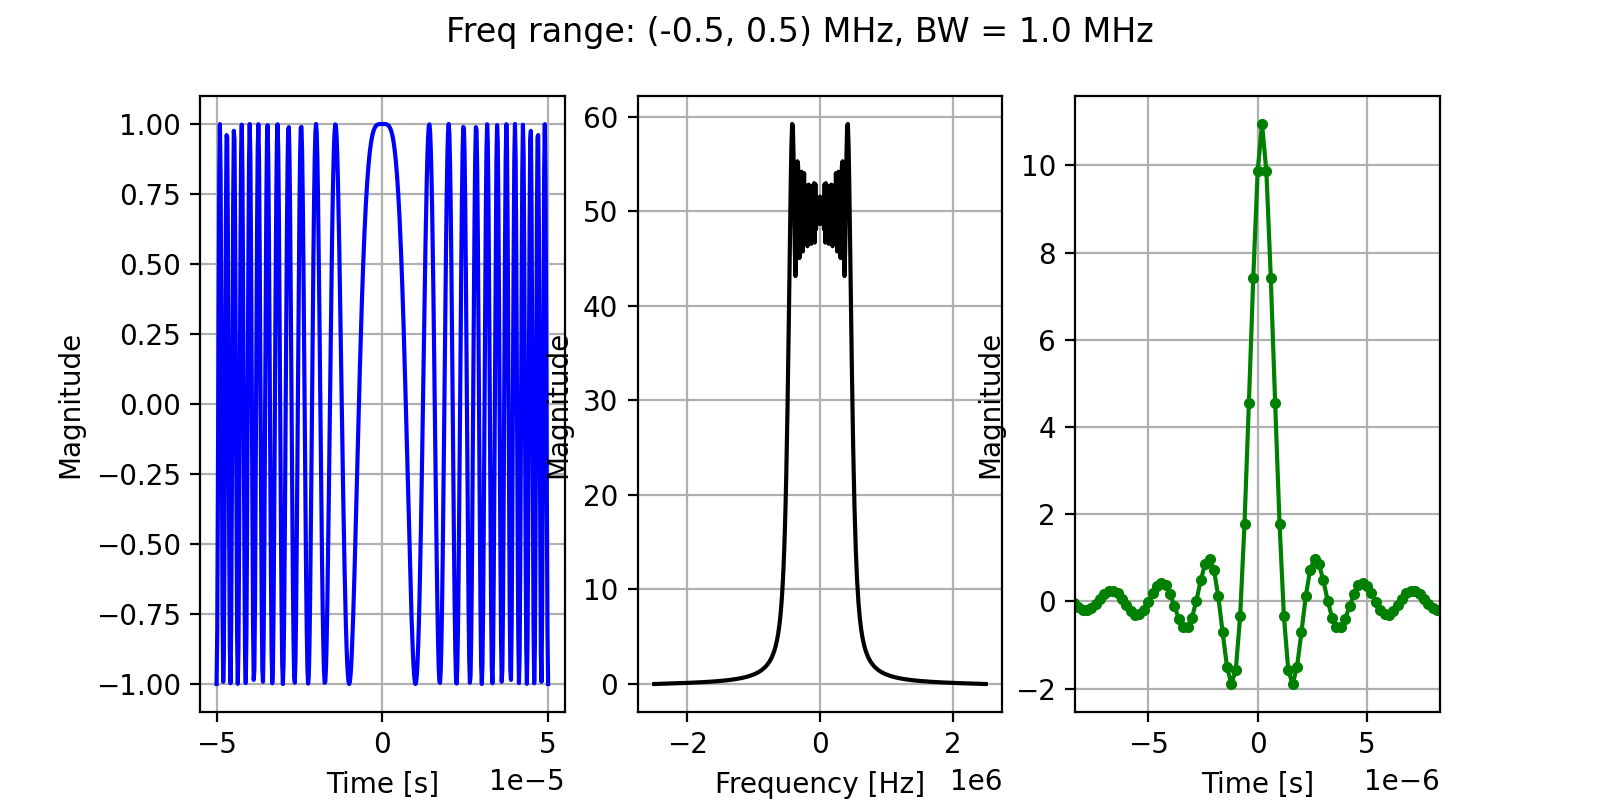

Text(0.5, 0.98, 'Freq range: (-0.5, 0.5) MHz, BW = 1.0 MHz')

In [3]:
fc = 0
f_start, f_end = fc - s * tau / 2, fc + s * tau / 2
t, chirp = make_chirp(fc, s, tau, fs)

plot_chirp(t, chirp)
title = f"Freq range: ({f_start/1e6:.3g}, {f_end/1e6:.3g}) MHz, BW = {BW/1e6:.1f} MHz"

plt.suptitle(title)

<IPython.core.display.Javascript object>


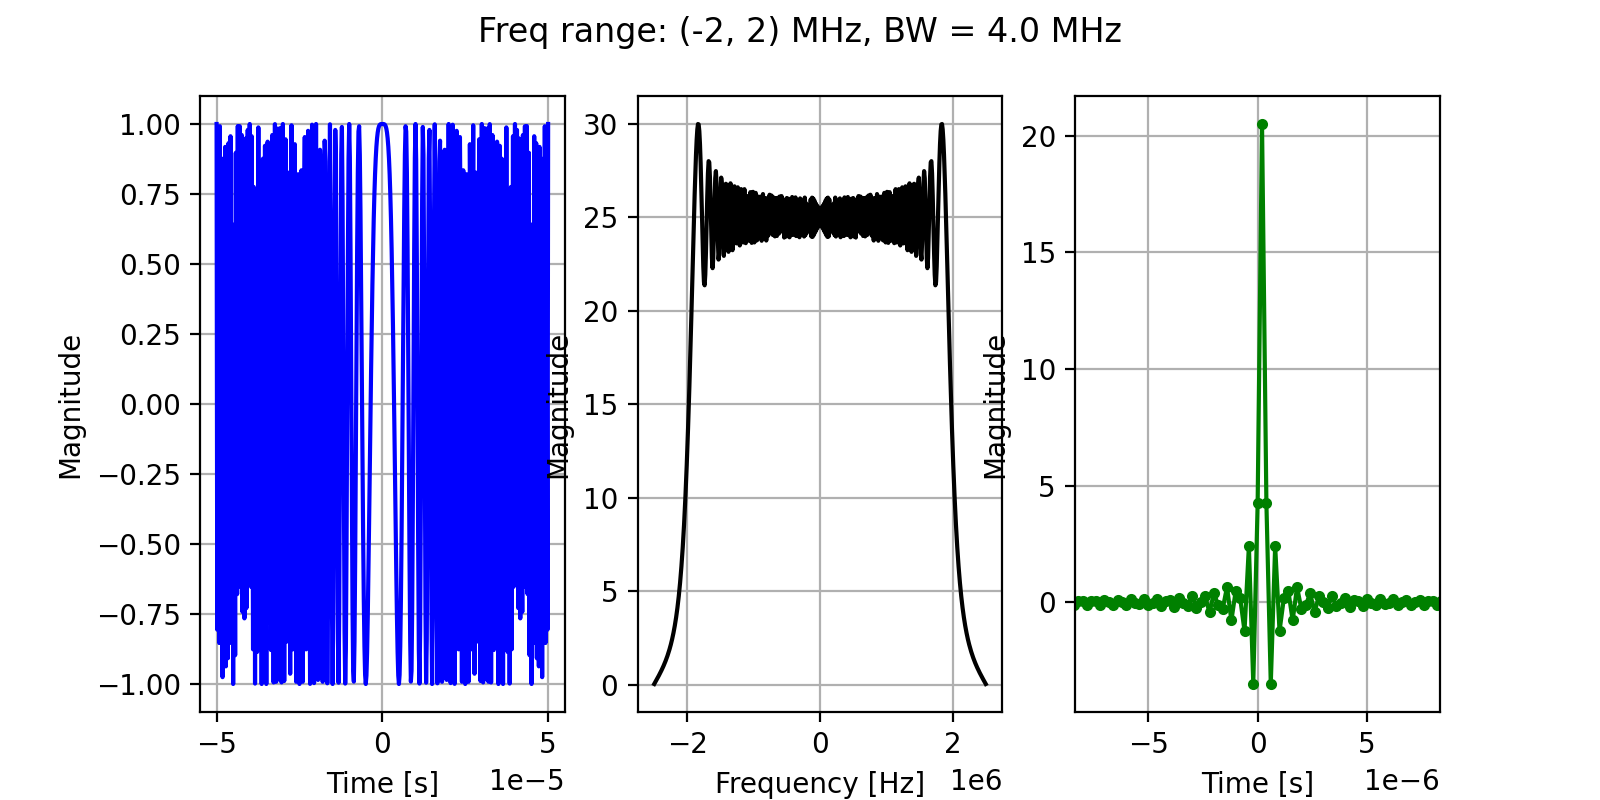

Text(0.5, 0.98, 'Freq range: (-2, 2) MHz, BW = 4.0 MHz')

In [4]:
BW = 4e6
s = BW / tau
fc = 0
f_start, f_end = fc - s * tau / 2, fc + s * tau / 2

t, chirp = make_chirp2(fc, BW, tau, fs)
plot_chirp(t, chirp)
title = f"Freq range: ({f_start/1e6:.3g}, {f_end/1e6:.3g}) MHz, BW = {BW/1e6:.1f} MHz"

plt.suptitle(title)

<IPython.core.display.Javascript object>


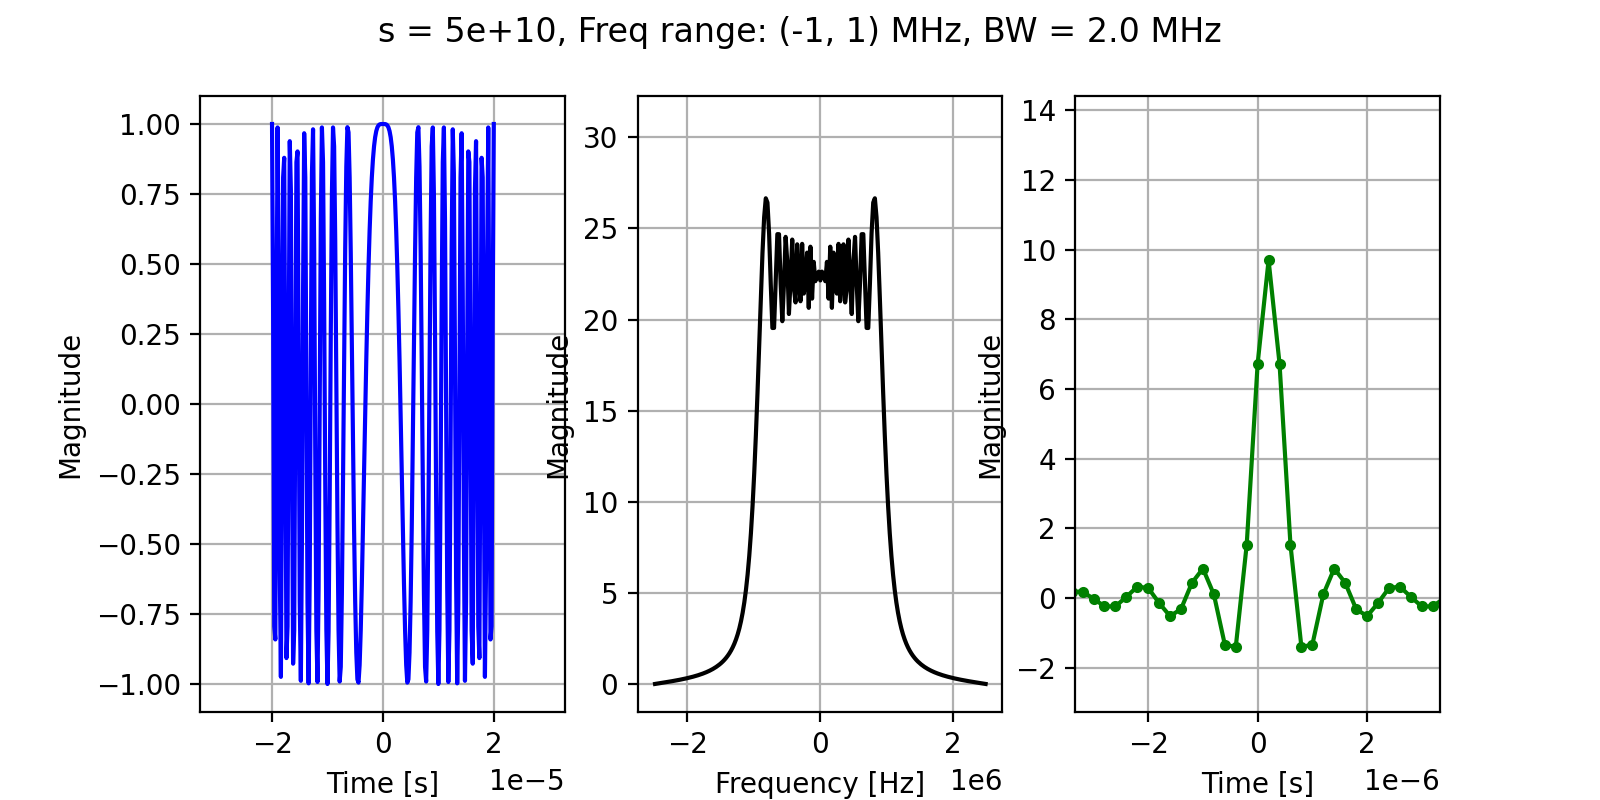

interactive(children=(FloatSlider(value=5e-05, description='tau', max=0.0001, min=1e-05, step=1e-05), FloatSli…

In [5]:
tau_range = (10e-6, 100e-6, 10e-6)
BW_range = (0.5e6, 5e6, 0.5e6)
fc_range = (-1e6, 1e6, 2e5)

fig, axes = plt.subplots(1, 3, figsize=(8, 4))


def _remove_lines(axes):
    [l.remove() for ax in axes for l in ax.lines]


@widgets.interact(tau=tau_range, BW=BW_range, fc=fc_range)
def make_and_plot_chirp(tau, BW, fc):
    _remove_lines(axes)

    s = BW / tau
    f_start, f_end = fc - s * tau / 2, fc + s * tau / 2
    t, chirp = make_chirp(fc, s, tau, fs)

    plot_chirp(t, chirp, axes=axes)
    title = f"{s = :.3g}, Freq range: ({f_start/1e6:.3g}, {f_end/1e6:.3g}) MHz, BW = {BW/1e6:.1f} MHz"
    print(title)
    fig.suptitle(title)

# Things to note about knobs

The **bandwidth**, $BW = f_{end} - f_{start} = s \tau$ is how much frequency spectrum we're using
- In general, more frequency used leads to more powerful radar properties
- Increasing BW above leads to 
    1. Narrower width on the sinc impulse response
    2. Higer peak on the impulse response
    3. Closer to ideal Rect function in frequency domain (assuming same $\tau$, see below)


The **time-bandwidth product** $BW * \tau$ is a key parameter
- Although an ideal linear chirp is a `rect` function in frequency, finite data means this is never achieved
- Larger time-bandwidth products become **closer to ideal chirps** where the **frequency spectrum approaches a rect**

# Translating BW to resolution
When the peaks get narrower in the impulse response, this mean the **resolution is finer**.
The zeros of the sinc function  are at $\sim  \pm 1 / BW$ seconds.
This time width translates to a range resolution of $\delta = \frac{1}{BW} \frac{c}{2}$ meters.
- E.g. if the BW is only 1 MHz, this is a range resolution of 3e8 / 2 / 1e6 = 150 meters, not great for a satellite SAR system
- The Sentinel-1 satellites use ~40-60 MHz BW, meaning 3.75 - 2.5 meter range resolution (from space!)
    - https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1/single-look-complex/interferometric-wide-swath 
- Capella Space says that they use 500 Mhz of bandwidth:
    - 3e8 / 2 / 500e6 = 0.3 m, or 30 cm
    - They claim future satellites may use up to 1.2 GHz of BW, or 12.5 cm (~5 inches) of resolution
    - https://www.capellaspace.com/capella-unveils-worlds-highest-resolution-commercial-sar-imagery/

# Comparing non-chirp pulse with chirp

Note that the resolution doesn't get worse with a longer chirp pulse. We can make the pulse longer to increase the SNR, if we need to, and not degrade the range resolution.

The old pulse width was $\tau$ seconds. The new is $1 / BW$. The improvement is 
$$
\frac{\tau}{1/BW} = \tau BW
$$
or the time-bandwidth product. 
Another way to write the improvement is using the slope, where $BW = s \tau$: improvement is $\tau (s \tau) = s \tau^2$, so the improvement increases linearly with the slope and quadratically with longer pulse duration.
